In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import wandb

import models as m
import functions as f
from functions import dict_to_array, normalize_array

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

import networkx as nx
from networkx.convert_matrix import from_numpy_array
import hypernetx as hnx

from sklearn.model_selection import ParameterGrid

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Generating the fake dataset. 
# We decided that patients without Alzheimer's (class 0) would have a stronger connectivity of their brain regions in the top left corner of the correlation matrix. 
# This is a simplification of the real data, but it will allow us to test the model without the complications from the data.

def generate_correlation_matrix(dimensions, stronger_top_left, stronger_bottom_right, average_top_left, average_bottom_right, class_ratio=0.25):
    # Generate a random matrix
    matrix = np.zeros((dimensions, dimensions))
    
    # Introduce more 1's in the top-left corner for class 1 matrices
    for row in range(dimensions):
        for column in range(dimensions):
            if row <= column:
                if row < dimensions//2 and column < dimensions//2:
                    if stronger_top_left and random.random() < 0.75:
                        matrix[row, column] = 1
                    elif average_top_left and random.random() < 0.5:
                        matrix[row, column] = 1
                    else:
                        if random.random() < 0.25:
                            matrix[row, column] = 1
                elif row >= dimensions//2 and column >= dimensions//2:
                    if stronger_bottom_right and random.random() < 0.75:
                        matrix[row, column] = 1
                    elif average_bottom_right and random.random() < 0.5:
                        matrix[row, column] = 1
                    else:
                        if random.random() < 0.25:
                            matrix[row, column] = 1
                else:
                    if random.random() < 0.25:
                        matrix[row, column] = 1

    # Make the matrix symmetric
    corr_matrix = np.maximum(matrix, matrix.T)
    
    # Make the diagonal elements equal to 1
    np.fill_diagonal(corr_matrix, 1)
    
    return corr_matrix

def generate_dataset(num_samples, dimensions, class_ratio=0.25):
    num_class0 = int(num_samples * class_ratio)
    num_class1 = int(num_samples * class_ratio)
    num_class2 = int(num_samples * class_ratio)
    num_class3 = num_samples - num_class0 - num_class1 - num_class2
    
    class0_matrices = [generate_correlation_matrix(dimensions, stronger_top_left=True, stronger_bottom_right=True, average_top_left=False, average_bottom_right=False) for _ in range(num_class0)]
    class1_matrices = [generate_correlation_matrix(dimensions, stronger_top_left=True, stronger_bottom_right=True, average_top_left=False, average_bottom_right=True) for _ in range(num_class1)]
    class2_matrices = [generate_correlation_matrix(dimensions, stronger_top_left=False, stronger_bottom_right=False, average_top_left=False, average_bottom_right=True) for _ in range(num_class2)]
    class3_matrices = [generate_correlation_matrix(dimensions, stronger_top_left=False, stronger_bottom_right=False, average_top_left=False, average_bottom_right=False) for _ in range(num_class3)]

    
    labels = [0] * num_class0 + [1] * num_class1 + [2] * num_class2 + [3] * num_class3
    
    # Shuffle the data
    combined = list(zip(class0_matrices + class1_matrices + class2_matrices + class3_matrices, labels))
    random.shuffle(combined)
    corr_matrices, labels = zip(*combined)
    
    return corr_matrices, labels

In [4]:
# Defining the properties of our dataset
num_samples = 1000
dimensions = 116
class_ratio = 0.25  # Ratio of samples for classes 0, 1, and 2. Class 3 will have the remaining samples.
corr_matrices, labels = generate_dataset(num_samples, dimensions, class_ratio=class_ratio)

# matrices contain the generated correlation matrices
# labels contain the corresponding class labels

for i in range(5):
    print(corr_matrices[i])
    print(labels[i])
    print()

[[1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
3

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
2

[[1. 1. 1. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
2

[[1. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 1. 1.]]
0

[[1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]
1



# Running different models on this data

In [5]:
# Training function
stratify = True
def train_fake(model, filename, method_wandb, optimizer, criterion, w_decay, parameters, train_loader, valid_loader, test_loader=False, testing=False, n_epochs=80):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    max_valid_accuracy = 0
    test_accuracy = 0

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Fake_Alzheimers",
        # track hyperparameters and run metadata
        config = {
        "model type": method_wandb,
        "strat + w loss": stratify,
        "weight_decay": w_decay,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, test_accuracy, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy)
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy, "Test Accuracy": test_accuracy})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, test_accuracy, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy)
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy})
        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
        print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
        print(f'Max Validation Accuracy: {max_valid_accuracy:.4f}')

    if testing:
        print('Test Accuracy:', test_accuracy)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    plt.savefig(filename)
    plt.show()
    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy

## Graph Neural Networks

In [6]:
# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Fake4C_Raw_to_graph(InMemoryDataset):
    def __init__(self, root, corr_matrices, labels, transform=None, pre_transform=None):
        self.corr_matrices = corr_matrices
        self.labels = labels
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        graphs=[]
        for patient_idx, patient_matrix in enumerate(corr_matrices):
            # Here ROIs stands for Regions of Interest
            nbr_ROIs = patient_matrix.shape[0]
            edge_matrix = np.zeros((nbr_ROIs,nbr_ROIs))
            for j in range(nbr_ROIs):
                for k in range(nbr_ROIs):
                    edge_matrix[j,k] = patient_matrix[j,k]

            # Create a NetworkX graph from the edge matrix
            NetworkX_graph = from_numpy_array(edge_matrix)

            # Compute the degree, betweenness centrality, clustering coefficient, local efficiency for each node of the graph and the global efficiency of the graph
            degree_dict = dict(NetworkX_graph.degree())
            between_central_dict = nx.betweenness_centrality(NetworkX_graph)
            cluster_coeff_dict = nx.clustering(NetworkX_graph)
            global_eff = nx.global_efficiency(NetworkX_graph)
            local_eff_dict = {}
            for node in NetworkX_graph.nodes():
                subgraph_neighb = NetworkX_graph.subgraph(NetworkX_graph.neighbors(node))
                if subgraph_neighb.number_of_nodes() > 1:
                    efficiency = nx.global_efficiency(subgraph_neighb)
                else:
                    efficiency = 0.0
                local_eff_dict[node] = efficiency

            # Convert the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency dictionaries to NumPy arrays then normalize them
            degree_array = dict_to_array(degree_dict)
            degree_array_norm = normalize_array(degree_array)

            between_central_array = dict_to_array(between_central_dict)
            between_central_array_norm = normalize_array(between_central_array)

            local_efficiency_array = dict_to_array(local_eff_dict)
            local_eff_array_norm = normalize_array(local_efficiency_array)

            ratio_local_global_array = dict_to_array(local_eff_dict) / global_eff
            ratio_local_global_array_norm = normalize_array(ratio_local_global_array)

            cluster_coeff_array = dict_to_array(cluster_coeff_dict)
            cluster_coeff_array_norm = normalize_array(cluster_coeff_array)

            # Initializing an array for the graph features
            x_array = np.stack([degree_array_norm, between_central_array_norm, local_eff_array_norm, cluster_coeff_array_norm, ratio_local_global_array_norm], axis=-1)
            x_array = x_array.astype(np.float32)

            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(x_array, dtype=torch.float)

            # Create a Pytorch Geometric Data object from the NetworkX
            graph_data = from_networkx(NetworkX_graph)
            ## The feature matrix of the graph is the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency of each node
            graph_data.x = x
            ## The target/output variable that we want to predict is the diagnostic label of the patient
            graph_data.y = float(labels[patient_idx])
            graphs.append(graph_data)
            print('done with patient', patient_idx)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])


### GCN

In [7]:
os.environ['WANDB_NOTEBOOK_NAME']="Fake4C_GCN.ipynb"
method = 'GCN_4C'

In [8]:
root = f'Fake4C_Raw_to_graph/model{method}'
dataset = Fake4C_Raw_to_graph(root, corr_matrices, labels)

data = dataset[0]

print()
print(data)
print('=============================================================')

# Some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...


done with patient 0
done with patient 1
done with patient 2
done with patient 3
done with patient 4
done with patient 5
done with patient 6
done with patient 7
done with patient 8
done with patient 9
done with patient 10
done with patient 11
done with patient 12
done with patient 13
done with patient 14
done with patient 15
done with patient 16
done with patient 17
done with patient 18
done with patient 19
done with patient 20
done with patient 21
done with patient 22
done with patient 23
done with patient 24
done with patient 25
done with patient 26
done with patient 27
done with patient 28
done with patient 29
done with patient 30
done with patient 31
done with patient 32
done with patient 33
done with patient 34
done with patient 35
done with patient 36
done with patient 37
done with patient 38
done with patient 39
done with patient 40
done with patient 41
done with patient 42
done with patient 43
done with patient 44
done with patient 45
done with patient 46
done with patient 47
do

Done!


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Fake4C_GCN

Number of training graphs: 700
Number of validation graphs: 100
Number of test graphs: 200
Number of classes: 4
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: mathilde-cros (alzheimers-cl). Use `wandb login --relogin` to force relogin
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch 1/80
Train Loss: 1.3830, Validation Loss: 1.3805
Train Accuracy: 0.2509, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 2/80
Train Loss: 1.3788, Validation Loss: 1.3761
Train Accuracy: 0.2495, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 3/80
Train Loss: 1.3746, Validation Loss: 1.3715
Train Accuracy: 0.2495, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 4/80
Train Loss: 1.3695, Validation Loss: 1.3657
Train Accuracy: 0.2505, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 5/80
Train Loss: 1.3632, Validation Loss: 1.3592
Train Accuracy: 0.2514, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 6/80
Train Loss: 1.3568, Validation Loss: 1.3516
Train Accuracy: 0.2495, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 7/80
Train Loss: 1.3487, Validation Loss: 1.3429
Train Accuracy: 0.2505, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 8/80
Train Loss: 1.34

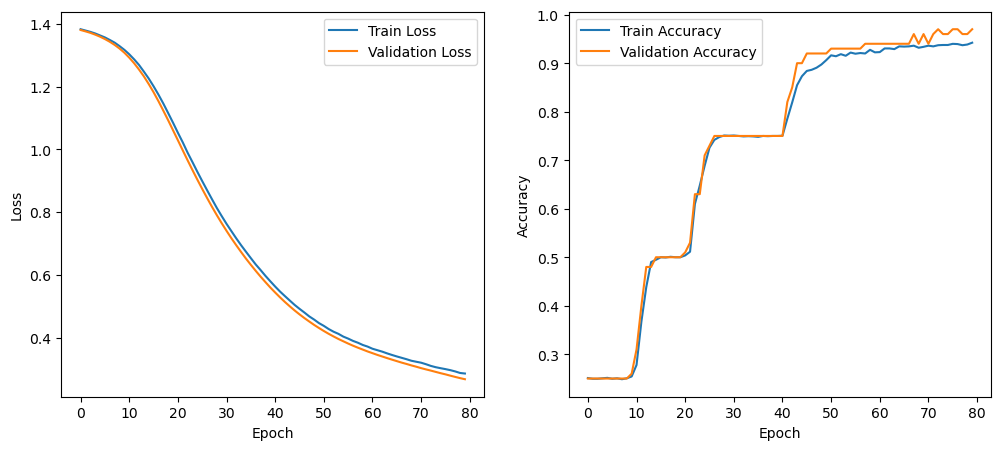

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Max Valid Accuracy,▁▁▁▁▁▂▃▃▃▃▄▅▅▆▆▆▆▆▆▆▆▇▇█████████████████
Test Accuracy,▁▁▁▁▁▂▃▃▃▃▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇███████████████
Train Accuracy,▁▁▁▁▁▁▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇████████████████
Train Loss,█████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▂▃▃▃▃▄▅▅▆▆▆▆▆▆▆▆▇▇█████████████████
Validation Loss,█████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Max Valid Accuracy,0.97
Test Accuracy,0.94
Train Accuracy,0.94223
Train Loss,0.28553
Validation Accuracy,0.97


In [9]:
param_grid = {
    'learning_rate': [0.0001],
    'hidden_channels': [64],
    'num_layers': [1],
    'dropout_rate': [0.0],
    'weight_decay': [0.0001]
}

# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset, stratify)

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 800
in_channels = 5
nbr_classes = 4
stratify = True
method_wandb = 'GCN_4C'
# Train using each combination
for params in param_combinations:
    filename = f'Fake4C_Models/GCN/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = m.GCN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        if stratify:
            diag_lab = [0 , 1, 2, 3]
            class_freq = []
            for i in diag_lab:
                class_freq.append(np.count_nonzero(torch.Tensor(y_train) == i))
            class_freq = torch.FloatTensor(class_freq)
            class_weights = 1 / class_freq
            class_weights /= class_weights.sum()
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss() 
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = train_fake(model, filename, method_wandb, optimizer, criterion, w_decay, parameters, train_loader, valid_loader, test_loader, testing=True, n_epochs=80)

### GAT

In [10]:
os.environ['WANDB_NOTEBOOK_NAME']="Fake4C_GAT.ipynb"
method = 'GAT_4C'

In [11]:
root = f'Fake4C_Raw_to_graph/model{method}'
dataset = Fake4C_Raw_to_graph(root, corr_matrices, labels)

Processing...


done with patient 0
done with patient 1
done with patient 2
done with patient 3
done with patient 4
done with patient 5
done with patient 6
done with patient 7
done with patient 8
done with patient 9
done with patient 10
done with patient 11
done with patient 12
done with patient 13
done with patient 14
done with patient 15
done with patient 16
done with patient 17
done with patient 18
done with patient 19
done with patient 20
done with patient 21
done with patient 22
done with patient 23
done with patient 24
done with patient 25
done with patient 26
done with patient 27
done with patient 28
done with patient 29
done with patient 30
done with patient 31
done with patient 32
done with patient 33
done with patient 34
done with patient 35
done with patient 36
done with patient 37
done with patient 38
done with patient 39
done with patient 40
done with patient 41
done with patient 42
done with patient 43
done with patient 44
done with patient 45
done with patient 46
done with patient 47
do

Done!


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of training graphs: 700
Number of validation graphs: 100
Number of test graphs: 200
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch 1/80
Train Loss: 1.3829, Validation Loss: 1.3754
Train Accuracy: 0.2666, Validation Accuracy: 0.4800
Max Validation Accuracy: 0.4800
Epoch 2/80
Train Loss: 1.3666, Validation Loss: 1.3549
Train Accuracy: 0.5005, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 3/80
Train Loss: 1.3380, Validation Loss: 1.3149
Train Accuracy: 0.4991, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 4/80
Train Loss: 1.2847, Validation Loss: 1.2474
Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 5/80
Train Loss: 1.2054, Validation Loss: 1.1544
Train Accuracy: 0.5019, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 6/80
Train Loss: 1.1070, Validation Loss: 1.0496
Train Accuracy: 0.5052, Validation Accuracy: 0.5200
Max Validation Accuracy: 0.5200
Epoch 7/80
Train Loss: 1.0004, Validation Loss: 0.9437
Train Accuracy: 0.5852, Validation Accuracy: 0.6700
Max Validation Accuracy: 0.6700
Epoch 8/80
Train Loss: 0.90

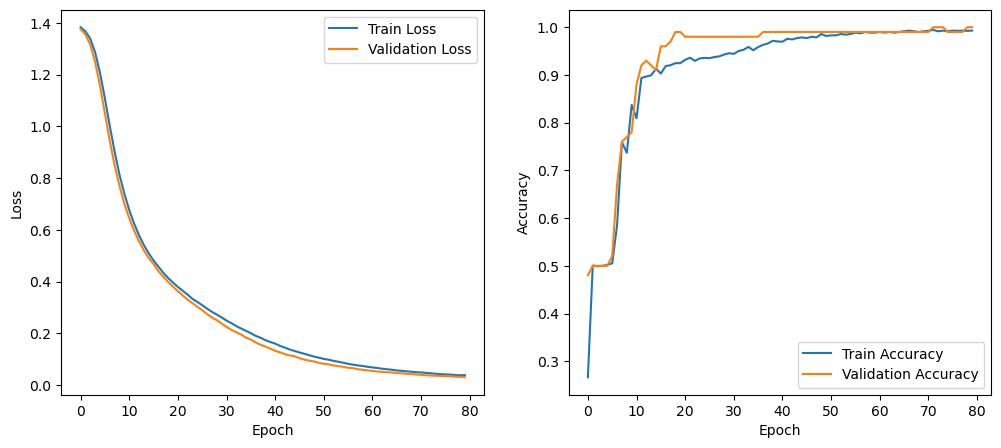

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Max Valid Accuracy,▁▁▁▄▅▆▇▇▇███████████████████████████████
Test Accuracy,▁▁▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
Train Accuracy,▁▃▃▄▆▆▇▇▇▇▇▇▇▇██████████████████████████
Train Loss,██▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▄▅▆▇▇▇███████████████████████████████
Validation Loss,██▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Max Valid Accuracy,1.0
Test Accuracy,0.985
Train Accuracy,0.9929
Train Loss,0.03811
Validation Accuracy,1.0


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch 1/80
Train Loss: 1.3811, Validation Loss: 1.3737
Train Accuracy: 0.2505, Validation Accuracy: 0.2500
Max Validation Accuracy: 0.2500
Epoch 2/80
Train Loss: 1.3649, Validation Loss: 1.3530
Train Accuracy: 0.2533, Validation Accuracy: 0.3100
Max Validation Accuracy: 0.3100
Epoch 3/80
Train Loss: 1.3368, Validation Loss: 1.3145
Train Accuracy: 0.5526, Validation Accuracy: 0.7500
Max Validation Accuracy: 0.7500
Epoch 4/80
Train Loss: 1.2820, Validation Loss: 1.2379
Train Accuracy: 0.7240, Validation Accuracy: 0.6600
Max Validation Accuracy: 0.7500
Epoch 5/80
Train Loss: 1.1855, Validation Loss: 1.1152
Train Accuracy: 0.6141, Validation Accuracy: 0.6000
Max Validation Accuracy: 0.7500
Epoch 6/80
Train Loss: 1.0551, Validation Loss: 0.9798
Train Accuracy: 0.5966, Validation Accuracy: 0.6300
Max Validation Accuracy: 0.7500
Epoch 7/80
Train Loss: 0.9273, Validation Loss: 0.8608
Train Accuracy: 0.6122, Validation Accuracy: 0.7000
Max Validation Accuracy: 0.7500
Epoch 8/80
Train Loss: 0.81

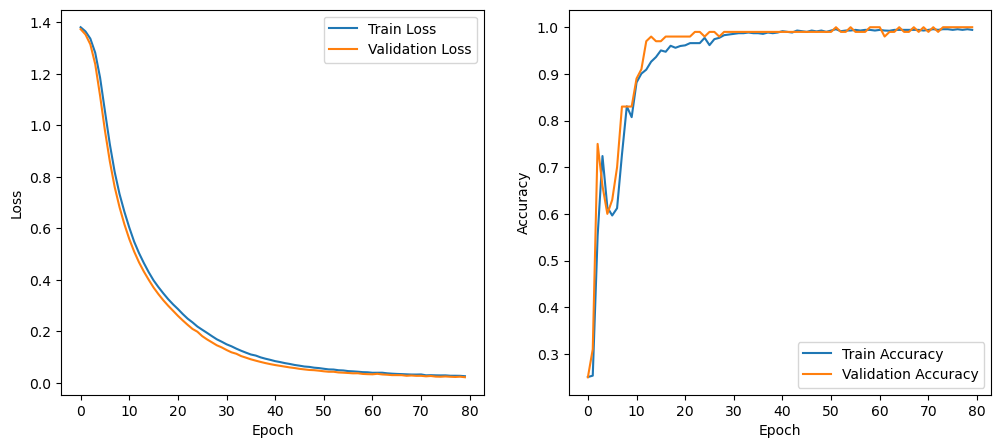

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Max Valid Accuracy,▁▆▆▆▆▇██████████████████████████████████
Test Accuracy,▁▆▆▆▆▇██████████████████████████████████
Train Accuracy,▁▄▄▄▆▇▇▇████████████████████████████████
Train Loss,██▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▄▅▆▇██████████████████████████████████
Validation Loss,██▇▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Max Valid Accuracy,1.0
Test Accuracy,0.98
Train Accuracy,0.99432
Train Loss,0.02585
Validation Accuracy,1.0


In [12]:
param_grid = {
    'learning_rate': [0.0001],
    'hidden_channels': [64],
    'num_layers': [1],
    'dropout_rate': [0.0],
    'weight_decay': [0.0001],
    'heads': [3, 4]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 80
in_channels = 5
nbr_classes = 4
stratify = True
method_wandb = 'GAT_4C'

# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset, stratify)

# Train using each combination
for params in param_combinations:
    filename = f'Fake4C_Models/GAT/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_heads{params["heads"]}_wdecay{params["weight_decay"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate'], params['heads']]
        model = m.GAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
        if stratify:
            diag_lab = [0 , 1, 2, 3]
            class_freq = []
            for i in diag_lab:
                class_freq.append(np.count_nonzero(torch.Tensor(y_train) == i))
            class_freq = torch.FloatTensor(class_freq)
            class_weights = 1 / class_freq
            class_weights /= class_weights.sum()
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss() 
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = train_fake(model, filename, method_wandb, optimizer, criterion, w_decay, parameters, train_loader, valid_loader, test_loader, testing=True, n_epochs=80)



# Hypergraph Neural Networks

In [14]:
class Fake4C_Raw_to_Hypergraph(InMemoryDataset):
    def __init__(self, root, hg_data_path, corr_matrices, labels, transform=None, pre_transform=None):
        self.labels = labels
        self.corr_matrices = corr_matrices
        self.hg_data_path = hg_data_path
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        # Loading the prebuilt hypergraphs and the correlation matrices
        hg_dict_list = f.load_hg_dict(self.hg_data_path)

        graphs=[]
        for patient_idx, patient_hg in enumerate(hg_dict_list):
            # Create a NetworkX graph from the hypergraph matrix
            hypergraph = hnx.Hypergraph(patient_hg)

            # Concatenate the matrix profiling features to the feature array
            x_array = corr_matrices[patient_idx]
            x_array = x_array.astype(np.float32)
            x = torch.tensor(x_array, dtype=torch.float)

            # Create a Pytorch Geometric Data object
            edge_index0 = []
            edge_index1 = []
            i = 0
            for hyperedge, nodes in hypergraph.incidence_dict.items():
                edge_index0 = np.concatenate((edge_index0, nodes), axis=0)
                for j in range(len(nodes)):
                    edge_index1.append(i)
                i += 1
            edge_index = np.stack([[int(x) for x in edge_index0], edge_index1], axis=0)
            y = torch.tensor(float(labels[patient_idx]))
            hg_data = Data(x=x, edge_index=torch.tensor(edge_index, dtype=torch.long), y=y)
            graphs.append(hg_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [19]:
# Defining functions to save the fake hypergraphs
def save_fake_hypergraph(hg_dict, directory, method, id):
    dir = f'{directory}/{method}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    with open(f'{dir}/{id}.pkl', 'wb') as f:
        pkl.dump(hg_dict, f)
    return

def save_all_fake_hypergraphs(method_list, corr_matrices, labels):
    for i, patient_matrix in enumerate(corr_matrices):
        print(f'Processing patient {i}')
        for method in method_list:
            if method == 'maximal_clique':
                root = f'Fake4C_Raw_to_graph/model{method}'
                dataset = Fake4C_Raw_to_graph(root, corr_matrices, labels)
                graph = f.r2g_to_nx(dataset[i])
                _, hg_dict = m.graph_to_hypergraph_max_cliques(graph)
            elif method == 'knn':
                k_neighbors = 3
                _, hg_dict = m.generate_hypergraph_from_knn(patient_matrix, k_neighbors)
            save_fake_hypergraph(hg_dict, 'Fake_hypergraphs_4C', method, i)
            print(f'Patient {i} processed and saved for the {method}')


In [20]:
save_all_fake_hypergraphs(['maximal_clique', 'knn'], corr_matrices, labels)

Processing patient 0


Processing...


done with patient 0
done with patient 1
done with patient 2
done with patient 3
done with patient 4
done with patient 5
done with patient 6
done with patient 7
done with patient 8
done with patient 9
done with patient 10
done with patient 11
done with patient 12
done with patient 13
done with patient 14
done with patient 15
done with patient 16
done with patient 17
done with patient 18
done with patient 19
done with patient 20
done with patient 21
done with patient 22
done with patient 23
done with patient 24
done with patient 25
done with patient 26
done with patient 27
done with patient 28
done with patient 29
done with patient 30
done with patient 31
done with patient 32
done with patient 33
done with patient 34
done with patient 35
done with patient 36
done with patient 37
done with patient 38
done with patient 39
done with patient 40
done with patient 41
done with patient 42
done with patient 43
done with patient 44
done with patient 45
done with patient 46
done with patient 47
do

Done!
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._da

Number of cliques: 1939
Maximum clique size: 6
Patient 0 processed and saved for the maximal_clique


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 0 processed and saved for the knn
Processing patient 1
Number of cliques: 8523
Maximum clique size: 10


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 1 processed and saved for the maximal_clique
Patient 1 processed and saved for the knn
Processing patient 2
Number of cliques: 7657
Maximum clique size: 10


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 2 processed and saved for the maximal_clique
Patient 2 processed and saved for the knn
Processing patient 3
Number of cliques: 108324
Maximum clique size: 18


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 3 processed and saved for the maximal_clique
Patient 3 processed and saved for the knn
Processing patient 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 302422
Maximum clique size: 24


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 4 processed and saved for the maximal_clique
Patient 4 processed and saved for the knn
Processing patient 5
Number of cliques: 1745
Maximum clique size: 6


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 5 processed and saved for the maximal_clique
Patient 5 processed and saved for the knn
Processing patient 6
Number of cliques: 7989
Maximum clique size: 10


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 6 processed and saved for the maximal_clique
Patient 6 processed and saved for the knn
Processing patient 7
Number of cliques: 136688
Maximum clique size: 17


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 7 processed and saved for the maximal_clique
Patient 7 processed and saved for the knn
Processing patient 8


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 8150
Maximum clique size: 10


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 8 processed and saved for the maximal_clique
Patient 8 processed and saved for the knn
Processing patient 9
Number of cliques: 1954
Maximum clique size: 6


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 9 processed and saved for the maximal_clique
Patient 9 processed and saved for the knn
Processing patient 10
Number of cliques: 143496
Maximum clique size: 17


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 10 processed and saved for the maximal_clique
Patient 10 processed and saved for the knn
Processing patient 11


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 6884
Maximum clique size: 10


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 11 processed and saved for the maximal_clique
Patient 11 processed and saved for the knn
Processing patient 12
Number of cliques: 1746
Maximum clique size: 6


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 12 processed and saved for the maximal_clique
Patient 12 processed and saved for the knn
Processing patient 13
Number of cliques: 133502
Maximum clique size: 16


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 13 processed and saved for the maximal_clique
Patient 13 processed and saved for the knn
Processing patient 14


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 355437
Maximum clique size: 24


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 14 processed and saved for the maximal_clique


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 14 processed and saved for the knn
Processing patient 15
Number of cliques: 148802
Maximum clique size: 19


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 15 processed and saved for the maximal_clique
Patient 15 processed and saved for the knn
Processing patient 16
Number of cliques: 1770
Maximum clique size: 6


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 16 processed and saved for the maximal_clique
Patient 16 processed and saved for the knn
Processing patient 17
Number of cliques: 98710
Maximum clique size: 18


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 17 processed and saved for the maximal_clique
Patient 17 processed and saved for the knn
Processing patient 18


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 7712
Maximum clique size: 9


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Patient 18 processed and saved for the maximal_clique
Patient 18 processed and saved for the knn
Processing patient 19
Number of cliques: 2010
Maximum clique size: 5
Patient 19 processed and saved for the maximal_clique
Patient 19 processed and saved for the knn
Processing patient 20


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 1917
Maximum clique size: 6
Patient 20 processed and saved for the maximal_clique
Patient 20 processed and saved for the knn
Processing patient 21


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

Number of cliques: 382741
Maximum clique size: 24


### HG with KNN Method

In [ ]:
os.environ['WANDB_NOTEBOOK_NAME']="Fake4C_HGKNN.ipynb"
method = 'HGKNN_4C'

In [ ]:
# Building the graphs
hg_data_path = f'Fake_hypergraphs/{method}/'
root = f'Fake4C_Raw_to_hypergraph/model_{method}'
dataset = Fake4C_Raw_to_Hypergraph(root, hg_data_path, corr_matrices, labels)

In [ ]:
# HGConv with KNN method

param_grid = {
    'learning_rate': [0.0001],
    'hidden_channels': [64],
    'num_layers': [1],
    'dropout_rate': [0.0],
    'weight_decay': [0.0001]
}

# Creating the train, validation and test sets
stratify = True
train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset, stratify)

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 80
in_channels = 5
nbr_classes = 4
method_wandb = 'HGKNN_4C'

# Train using each combination
for params in param_combinations:
    filename = f'Fake4C_Models/HGKNN/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = m.HGConv(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        if stratify:
            diag_lab = [0 , 1, 2, 3]
            class_freq = []
            for i in diag_lab:
                class_freq.append(np.count_nonzero(torch.Tensor(y_train) == i))
            class_freq = torch.FloatTensor(class_freq)
            class_weights = 1 / class_freq
            class_weights /= class_weights.sum()
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss() 
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = train_fake(model, filename, method_wandb, optimizer, criterion, w_decay, parameters, train_loader, valid_loader, test_loader, testing=True, n_epochs=800)

### HGConv with Maximal Clique Method

In [ ]:
os.environ['WANDB_NOTEBOOK_NAME']="Fake4C_HGMC.ipynb"
method = 'HGMC_4C'

In [ ]:
# Building the graphs
hg_data_path = f'Fake_hypergraphs/{method}/'
root = f'Fake4C_Raw_to_hypergraph/model_{method}'
dataset = Fake4C_Raw_to_Hypergraph(root, hg_data_path, corr_matrices, labels)

In [ ]:
# HGConv with KNN method

param_grid = {
    'learning_rate': [0.0001],
    'hidden_channels': [64],
    'num_layers': [1],
    'dropout_rate': [0.0],
    'weight_decay': [0.0001]
}

# Creating the train, validation and test sets
stratify = True
train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset, stratify)

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 80
in_channels = 5
nbr_classes = 4
method_wandb = 'HGMC_4C'

# Train using each combination
for params in param_combinations:
    filename = f'Fake4C_Models/HGMC/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = m.HGConv(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        if stratify:
            diag_lab = [0 , 1, 2, 3]
            class_freq = []
            for i in diag_lab:
                class_freq.append(np.count_nonzero(torch.Tensor(y_train) == i))
            class_freq = torch.FloatTensor(class_freq)
            class_weights = 1 / class_freq
            class_weights /= class_weights.sum()
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss() 
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = train_fake(model, filename, method_wandb, optimizer, criterion, w_decay, parameters, train_loader, valid_loader, test_loader, testing=True, n_epochs=800)